In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors
import math
import numpy as np
import json

import datetime as dt
import missingno as msno
from textwrap import wrap

In [34]:
# jamstones = pd.read_csv('../../../fyp_data/jamstones.csv')
# lavval = pd.read_csv("../../../fyp_data/lavval.csv")
# newagefsg = pd.read_csv("../../../fyp_data/newagefsg.csv")

jamstones = pd.read_csv('../jamstones.csv')
lavval = pd.read_csv("../lavval.csv")
newagefsg = pd.read_csv("../newagefsg.csv")


C:\Users\wslee.2019\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: DtypeWarning: Columns (49,51,56) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Get Dataset

In [35]:
jamstones[['id', 'created_at','customer', 'line_items', 'total_price', 'shipping_address']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10065 entries, 0 to 10064
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                10065 non-null  int64  
 1   created_at        10065 non-null  object 
 2   customer          9744 non-null   object 
 3   line_items        10065 non-null  object 
 4   total_price       10065 non-null  float64
 5   shipping_address  8669 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 471.9+ KB


In [36]:
# Preprocessing

#helper functions
def trim_all_columns(df):
    """
    Trim whitespace from ends of each value across all series in dataframe
    """
    trim_strings = lambda x: x.strip() if isinstance(x, str) else x
    return df.applymap(trim_strings)

def source(x):
    if 'shopee' in x.lower():
        return 'Shopee'
    elif 'instagram' in x.lower():
        return 'Instagram'
    else:
        return 'Shopify'
    
def check_format(row):
    if type(row)==str:
        if ((row[0] == '['and row[len(row)-1] == ']' and row[1] == '{'and row[len(row)-2] == '}') or (row[0] == '{'and row[len(row)-1] == '}') )and len(row)>10:
            return True
    else:
        return False

def preprocessing(df):
    df_copy = df.copy()[['id', 'created_at','customer','line_items', 'total_price', 'shipping_address']]

    df_copy['format_check'] = df_copy.apply(lambda x: 'pass' if check_format(x.line_items) else math.nan, axis=1)
    df_copy['format_check'] = df_copy.apply(lambda x: 'pass' if (check_format(x.customer) and x.format_check!=math.nan) else math.nan, axis=1)
    df_copy.dropna(inplace = True)
    
    df_copy['created_at'] = df_copy['created_at'].apply(lambda x: pd.to_datetime(x))

    
    df_copy.line_items = df_copy.line_items.apply(eval).apply(json.dumps)
    df_copy.customer = df_copy.customer.apply(eval).apply(json.dumps)

    df_copy.shipping_address = df_copy.shipping_address.apply(eval).apply(json.dumps)

    # Column names that contain JSON
    json_cols = ['customer', 'line_items','shipping_address']

    def clean_json(x):
        "Create apply function for decoding JSON"
        return json.loads(x)

    # Apply the function column wise to each column of interest
    for x in json_cols:
        df_copy[x] = df_copy[x].apply(clean_json)        
    
    df_copy['customer_id'] = df_copy.apply(lambda x: x.customer['id'], axis=1)
    df_copy['freq'] = df_copy.groupby('customer_id')['customer_id'].transform('count')
    
    
    return df_copy

In [37]:
df_copy=preprocessing(jamstones)
df_copy

,id,created_at,customer,line_items,total_price,shipping_address,format_check,customer_id,freq
0,4174646214752,2022-02-28 00:57:49+08:00,"{'id': 5424535797856, 'email': None, 'accepts_...","[{'id': 10735968026720, 'admin_graphql_api_id'...",48.98,"{'first_name': 'Yurika', 'address1': '35 BANGK...",pass,5424535797856,1
1,4174601224288,2022-02-28 00:11:24+08:00,"{'id': 5390401241184, 'email': None, 'accepts_...","[{'id': 10735859531872, 'admin_graphql_api_id'...",87.10,"{'first_name': 'Eve Toh', 'address1': 'BLOCK 8...",pass,5390401241184,9
2,4174584152160,2022-02-27 23:53:03+08:00,"{'id': 5309196370016, 'email': None, 'accepts_...","[{'id': 10735819128928, 'admin_graphql_api_id'...",87.34,"{'first_name': 'Sylvia Ng', 'address1': 'BLOCK...",pass,5309196370016,11
3,4174516322400,2022-02-27 22:32:08+08:00,"{'id': 5387641520224, 'email': None, 'accepts_...","[{'id': 10735657025632, 'admin_graphql_api_id'...",32.28,"{'first_name': 'Crystal yap', 'address1': 'PAR...",pass,5387641520224,2
4,4174498693216,2022-02-27 22:07:14+08:00,"{'id': 5424407871584, 'email': 'naryssok@gmail...","[{'id': 10735617179744, 'admin_graphql_api_id'...",53.90,"{'first_name': 'Nary', 'address1': 'Block 233 ...",pass,5424407871584,1
...,...,...,...,...,...,...,...,...,...
10054,2570874159200,2020-07-24 21:53:18+08:00,"{'id': 3451201290336, 'email': 'joselyn999@hot...","[{'id': 5394215796832, 'admin_graphql_api_id':...",153.80,"{'first_name': 'Joselyn', 'address1': '82 Stra...",pass,3451201290336,1
10058,2570778706016,2020-07-24 20:26:35+08:00,"{'id': 3451115405408, 'email': 'bimorphia@hotm...","[{'id': 5394021417056, 'admin_graphql_api_id':...",49.90,"{'first_name': 'Josephine', 'address1': 'Blk 2...",pass,3451115405408,2
10059,2570731782240,2020-07-24 19:27:25+08:00,"{'id': 3451077099616, 'email': 'justbeingme-ev...","[{'id': 5393924325472, 'admin_graphql_api_id':...",129.80,"{'first_name': 'Eve', 'address1': '669 Hougang...",pass,3451077099616,1
10060,2570730242144,2020-07-24 19:24:56+08:00,"{'id': 3451077754976, 'email': 'yanniedonked@g...","[{'id': 5393920983136, 'admin_graphql_api_id':...",225.50,"{'first_name': 'YQ', 'address1': '107B Tampine...",pass,3451077754976,1


In [38]:
print(df_copy.isnull().values.sum())

0


In [39]:
jamstones_preprocessed = preprocessing(jamstones)
lavval_preprocessed = preprocessing(lavval)
newagefsg_preprocessed = preprocessing(newagefsg)

In [40]:
new_df = pd.concat([jamstones_preprocessed, lavval_preprocessed, newagefsg_preprocessed], ignore_index=True)
new_df

,id,created_at,customer,line_items,total_price,shipping_address,format_check,customer_id,freq
0,4174646214752,2022-02-28 00:57:49+08:00,"{'id': 5424535797856, 'email': None, 'accepts_...","[{'id': 10735968026720, 'admin_graphql_api_id'...",48.98,"{'first_name': 'Yurika', 'address1': '35 BANGK...",pass,5424535797856,1
1,4174601224288,2022-02-28 00:11:24+08:00,"{'id': 5390401241184, 'email': None, 'accepts_...","[{'id': 10735859531872, 'admin_graphql_api_id'...",87.10,"{'first_name': 'Eve Toh', 'address1': 'BLOCK 8...",pass,5390401241184,9
2,4174584152160,2022-02-27 23:53:03+08:00,"{'id': 5309196370016, 'email': None, 'accepts_...","[{'id': 10735819128928, 'admin_graphql_api_id'...",87.34,"{'first_name': 'Sylvia Ng', 'address1': 'BLOCK...",pass,5309196370016,11
3,4174516322400,2022-02-27 22:32:08+08:00,"{'id': 5387641520224, 'email': None, 'accepts_...","[{'id': 10735657025632, 'admin_graphql_api_id'...",32.28,"{'first_name': 'Crystal yap', 'address1': 'PAR...",pass,5387641520224,2
4,4174498693216,2022-02-27 22:07:14+08:00,"{'id': 5424407871584, 'email': 'naryssok@gmail...","[{'id': 10735617179744, 'admin_graphql_api_id'...",53.90,"{'first_name': 'Nary', 'address1': 'Block 233 ...",pass,5424407871584,1
...,...,...,...,...,...,...,...,...,...
13452,2676186022049,2020-08-30 19:55:55+08:00,"{'id': 3953183359137, 'email': None, 'accepts_...","[{'id': 5788143878305, 'admin_graphql_api_id':...",62.90,"{'first_name': 'Yana', 'address1': 'Blk 815 Ju...",pass,3953183359137,4
13453,2674319327393,2020-08-29 20:31:21+08:00,"{'id': 3948893175969, 'email': 'peiling.ng.1@g...","[{'id': 5785053888673, 'admin_graphql_api_id':...",135.00,"{'first_name': 'Pei Ling', 'address1': '8A Lor...",pass,3948893175969,1
13454,2673968054433,2020-08-29 15:32:21+08:00,"{'id': 3948014928033, 'email': 'maytbl59@gmail...","[{'id': 5784513413281, 'admin_graphql_api_id':...",61.00,"{'first_name': 'May May', 'address1': 'Blk 505...",pass,3948014928033,1
13455,2673190043809,2020-08-29 05:00:23+08:00,"{'id': 3946100785313, 'email': 'hltim@singnet....","[{'id': 5783188865185, 'admin_graphql_api_id':...",91.00,"{'first_name': 'Hwee Ling', 'address1': 'Blk 2...",pass,3946100785313,4


In [41]:
#aggregate df no preprocessing
df = new_df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13457 entries, 0 to 13456
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype                                
---  ------            --------------  -----                                
 0   id                13457 non-null  int64                                
 1   created_at        13457 non-null  datetime64[ns, pytz.FixedOffset(480)]
 2   customer          13457 non-null  object                               
 3   line_items        13457 non-null  object                               
 4   total_price       13457 non-null  float64                              
 5   shipping_address  13457 non-null  object                               
 6   format_check      13457 non-null  object                               
 7   customer_id       13457 non-null  int64                                
 8   freq              13457 non-null  int64                                
dtypes: datetime64[ns, pytz.FixedOffset(480)]

In [42]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,13457.0,3.806048e+12,5.531982e+11,2.195149e+12,3.727794e+12,3.965835e+12,4.099767e+12,4.693166e+12
total_price,13457.0,8.460461e+01,7.040411e+01,0.000000e+00,3.896000e+01,6.480000e+01,1.099000e+02,9.048100e+02
customer_id,13457.0,4.931217e+12,7.404013e+11,3.035305e+12,4.560505e+12,5.226530e+12,5.348984e+12,6.099009e+12
freq,13457.0,4.286617e+00,6.808279e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,5.000000e+01


In [43]:
n_orders = df.groupby(['customer_id'])['id'].nunique()
mult_orders_perc = np.sum(n_orders > 1) / df['customer_id'].nunique()
print(f'{100 * mult_orders_perc:.2f}% of customers ordered more than once.')

26.44% of customers ordered more than once.


C:\Users\wslee.2019\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


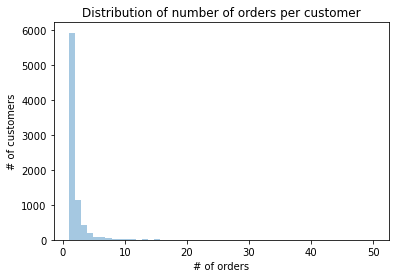

In [44]:
ax = sns.distplot(n_orders, kde=False, hist=True)
ax.set(title='Distribution of number of orders per customer',
       xlabel='# of orders', 
       ylabel='# of customers');

In [45]:
df = df[['customer_id', 'id', 'created_at']].drop_duplicates()

In [46]:
# # A function that will parse the date Time based cohort:  1 day of month
# def get_month(x): return dt.datetime(x.year, x.month, 1) 
# # Create transaction_date column based on month and store in TransactionMonth
# df['created_at'] = df['created_at'].apply(get_month) 
# # Grouping by customer_id and select the InvoiceMonth value
# grouping = df.groupby('customer_id')['created_at'] 
# # Assigning a minimum InvoiceMonth value to the dataset
# df['CohortMonth'] = grouping.transform('min')
# # printing top 5 rows
# print(df.head())

     customer_id             id created_at CohortMonth
0  5424535797856  4174646214752 2022-02-01  2022-02-01
1  5390401241184  4174601224288 2022-02-01  2022-01-01
2  5309196370016  4174584152160 2022-02-01  2021-11-01
3  5387641520224  4174516322400 2022-02-01  2022-01-01
4  5424407871584  4174498693216 2022-02-01  2022-02-01


In [47]:
# def get_date_int(df, column):
#     year = df[column].dt.year
#     month = df[column].dt.month
#     day = df[column].dt.day
#     return year, month, day
# # Getting the integers for date parts from the `InvoiceDay` column
# transcation_year, transaction_month, _ = get_date_int(df, 'created_at')
# # Getting the integers for date parts from the `CohortDay` column
# cohort_year, cohort_month, _ = get_date_int(df, 'CohortMonth')

In [48]:
# #  Get the  difference in years
# years_diff = transcation_year - cohort_year
# # Calculate difference in months
# months_diff = transaction_month - cohort_month
# """ Extract the difference in months from all previous values
#  "+1" in addeded at the end so that first month is marked as 1 instead of 0 for easier interpretation. 
#  """
# df['CohortIndex'] = years_diff * 12 + months_diff  + 1 
# print(df.head(5))

     customer_id             id created_at CohortMonth  CohortIndex
0  5424535797856  4174646214752 2022-02-01  2022-02-01            1
1  5390401241184  4174601224288 2022-02-01  2022-01-01            2
2  5309196370016  4174584152160 2022-02-01  2021-11-01            4
3  5387641520224  4174516322400 2022-02-01  2022-01-01            2
4  5424407871584  4174498693216 2022-02-01  2022-02-01            1


In [49]:
# # Counting daily active user from each chort
# grouping = df.groupby(['CohortMonth', 'CohortIndex'])
# # Counting number of unique customer Id's falling in each group of CohortMonth and CohortIndex
# cohort_data = grouping['customer_id'].apply(pd.Series.nunique)
# cohort_data = cohort_data.reset_index()
#  # Assigning column names to the dataframe created above
# cohort_counts = cohort_data.pivot(index='CohortMonth',
#                                  columns ='CohortIndex',
#                                  values = 'customer_id')
# # Printing top 5 rows of Dataframe
# cohort_data.head()

,CohortMonth,CohortIndex,customer_id
0,2020-06-01,1,43
1,2020-06-01,2,4
2,2020-06-01,3,2
3,2020-06-01,4,3
4,2020-06-01,5,5


In [50]:
# cohort_sizes = cohort_counts.iloc[:,0]
# retention = cohort_counts.divide(cohort_sizes, axis=0)
# # Coverting the retention rate into percentage and Rounding off.
# retention.round(3)*100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,21
CohortMonth,,,,,,,,,,,,,,,,,,,,
2020-06-01,100.0,9.3,4.7,7.0,11.6,2.3,2.3,NaN,NaN,2.3,2.3,NaN,2.3,NaN,2.3,NaN,2.3,NaN,NaN,2.3
2020-07-01,100.0,11.7,2.7,0.9,3.6,1.8,0.9,0.9,NaN,0.9,NaN,NaN,2.7,0.9,NaN,1.8,NaN,0.9,NaN,NaN
2020-08-01,100.0,5.6,4.2,3.8,3.1,1.4,1.4,3.1,1.4,0.7,1.4,2.1,1.7,0.7,NaN,1.4,1.7,0.7,1.0,NaN
2020-09-01,100.0,15.3,7.1,7.1,2.0,4.6,4.6,7.7,2.6,5.6,4.1,NaN,1.5,4.6,3.1,2.0,2.6,2.0,NaN,NaN
2020-10-01,100.0,11.0,6.4,2.1,5.5,3.7,3.0,3.0,3.4,2.1,NaN,0.9,1.5,1.8,1.2,1.8,1.5,NaN,NaN,NaN
2020-11-01,100.0,10.5,4.2,3.2,3.2,1.6,2.2,3.5,2.2,1.3,1.0,1.6,2.9,2.6,1.6,0.3,NaN,NaN,NaN,NaN
2020-12-01,100.0,5.3,3.2,2.0,2.0,2.6,2.6,2.0,0.6,1.2,0.6,0.9,1.2,0.3,0.9,NaN,NaN,NaN,NaN,NaN
2021-01-01,100.0,8.8,4.4,5.7,3.1,2.2,1.8,1.3,0.4,0.9,1.3,0.9,0.4,2.6,NaN,NaN,NaN,NaN,NaN,NaN
2021-02-01,100.0,9.6,7.2,3.2,3.6,2.0,2.4,1.6,1.2,1.6,0.8,0.4,1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
df['order_month'] = df['created_at'].dt.to_period('M')
df['cohort'] = df.groupby('customer_id')['created_at'] \
                 .transform('min') \
                 .dt.to_period('M') 

In [53]:

df_cohort = df.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('customer_id', 'nunique')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

In [54]:
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [57]:
cohort_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20
cohort,,,,,,,,,,,,,,,,,,,,
2020-06,43.0,4.0,2.0,3.0,5.0,1.0,1.0,NaN,NaN,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0
2020-07,111.0,13.0,3.0,1.0,4.0,2.0,1.0,1.0,NaN,1.0,NaN,NaN,3.0,1.0,NaN,2.0,NaN,1.0,NaN,NaN
2020-08,286.0,16.0,12.0,11.0,9.0,4.0,4.0,9.0,4.0,2.0,4.0,6.0,5.0,2.0,NaN,4.0,5.0,2.0,3.0,NaN
2020-09,196.0,30.0,14.0,14.0,4.0,9.0,9.0,15.0,5.0,11.0,8.0,NaN,3.0,9.0,6.0,4.0,5.0,4.0,NaN,NaN
2020-10,328.0,36.0,21.0,7.0,18.0,12.0,10.0,10.0,11.0,7.0,NaN,3.0,5.0,6.0,4.0,6.0,5.0,NaN,NaN,NaN
2020-11,313.0,33.0,13.0,10.0,10.0,5.0,7.0,11.0,7.0,4.0,3.0,5.0,9.0,8.0,5.0,1.0,NaN,NaN,NaN,NaN
2020-12,342.0,18.0,11.0,7.0,7.0,9.0,9.0,7.0,2.0,4.0,2.0,3.0,4.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN
2021-01,227.0,20.0,10.0,13.0,7.0,5.0,4.0,3.0,1.0,2.0,3.0,2.0,1.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-02,250.0,24.0,18.0,8.0,9.0,5.0,6.0,4.0,3.0,4.0,2.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

In [56]:
retention_matrix

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20
cohort,,,,,,,,,,,,,,,,,,,,
2020-06,1.0,0.093023,0.046512,0.069767,0.116279,0.023256,0.023256,NaN,NaN,0.023256,0.023256,NaN,0.023256,NaN,0.023256,NaN,0.023256,NaN,NaN,0.023256
2020-07,1.0,0.117117,0.027027,0.009009,0.036036,0.018018,0.009009,0.009009,NaN,0.009009,NaN,NaN,0.027027,0.009009,NaN,0.018018,NaN,0.009009,NaN,NaN
2020-08,1.0,0.055944,0.041958,0.038462,0.031469,0.013986,0.013986,0.031469,0.013986,0.006993,0.013986,0.020979,0.017483,0.006993,NaN,0.013986,0.017483,0.006993,0.01049,NaN
2020-09,1.0,0.153061,0.071429,0.071429,0.020408,0.045918,0.045918,0.076531,0.025510,0.056122,0.040816,NaN,0.015306,0.045918,0.030612,0.020408,0.025510,0.020408,NaN,NaN
2020-10,1.0,0.109756,0.064024,0.021341,0.054878,0.036585,0.030488,0.030488,0.033537,0.021341,NaN,0.009146,0.015244,0.018293,0.012195,0.018293,0.015244,NaN,NaN,NaN
2020-11,1.0,0.105431,0.041534,0.031949,0.031949,0.015974,0.022364,0.035144,0.022364,0.012780,0.009585,0.015974,0.028754,0.025559,0.015974,0.003195,NaN,NaN,NaN,NaN
2020-12,1.0,0.052632,0.032164,0.020468,0.020468,0.026316,0.026316,0.020468,0.005848,0.011696,0.005848,0.008772,0.011696,0.002924,0.008772,NaN,NaN,NaN,NaN,NaN
2021-01,1.0,0.088106,0.044053,0.057269,0.030837,0.022026,0.017621,0.013216,0.004405,0.008811,0.013216,0.008811,0.004405,0.026432,NaN,NaN,NaN,NaN,NaN,NaN
2021-02,1.0,0.096000,0.072000,0.032000,0.036000,0.020000,0.024000,0.016000,0.012000,0.016000,0.008000,0.004000,0.012000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


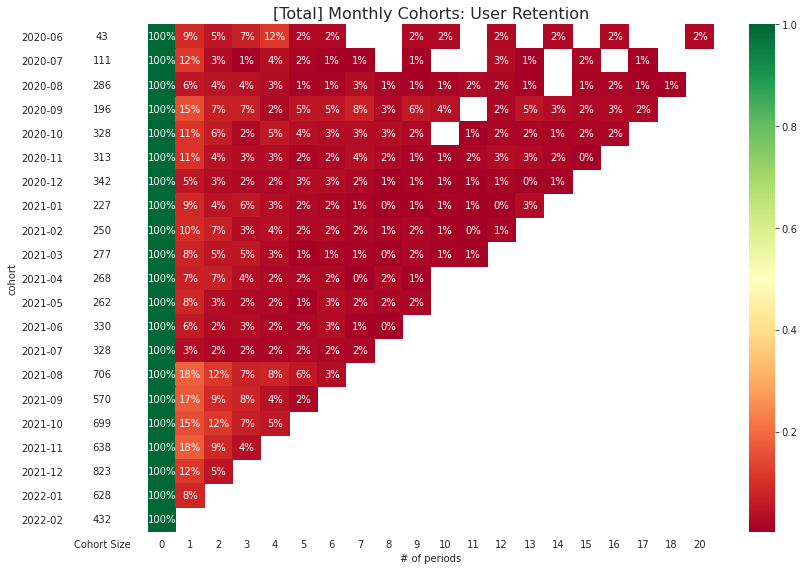

In [20]:

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', #YlGnBu (blue)
                ax=ax[1])
    ax[1].set_title('[Total] Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'Cohort Size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()
    plt.savefig('../customer_retention_output/total_cohort_analysis.pdf')

Jamstones

32.20% of customers ordered more than once.


C:\Users\wslee.2019\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


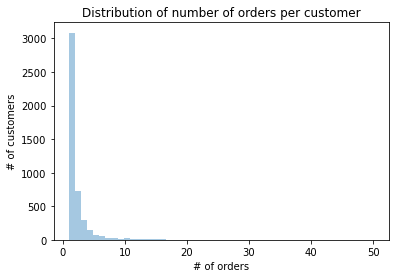

In [21]:
n_orders = jamstones_preprocessed.groupby(['customer_id'])['id'].nunique()
mult_orders_perc = np.sum(n_orders > 1) / jamstones_preprocessed['customer_id'].nunique()
print(f'{100 * mult_orders_perc:.2f}% of customers ordered more than once.')

ax = sns.distplot(n_orders, kde=False, hist=True)
ax.set(title='Distribution of number of orders per customer',
       xlabel='# of orders', 
       ylabel='# of customers');

C:\Users\wslee.2019\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


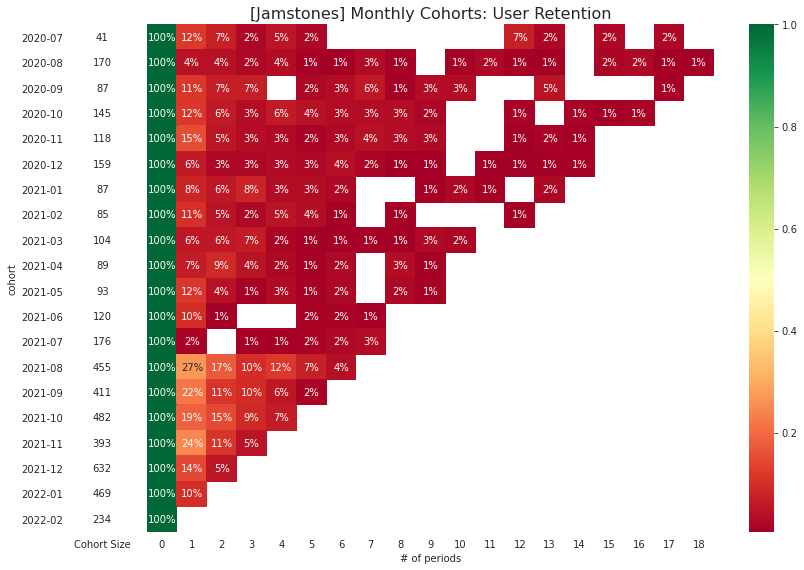

In [28]:
df = jamstones_preprocessed[['customer_id', 'id', 'created_at']].drop_duplicates()

df['order_month'] = df['created_at'].dt.to_period('M')
df['cohort'] = df.groupby('customer_id')['created_at'] \
                 .transform('min') \
                 .dt.to_period('M') 
df_cohort = df.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('customer_id', 'nunique')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)                                

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', #YlGnBu (blue)
                ax=ax[1])
    ax[1].set_title('[Jamstones] Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'Cohort Size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()
    plt.savefig('../customer_retention_output/jamstones_cohort_analysis.pdf')

Lavval

20.64% of customers ordered more than once.


C:\Users\wslee.2019\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


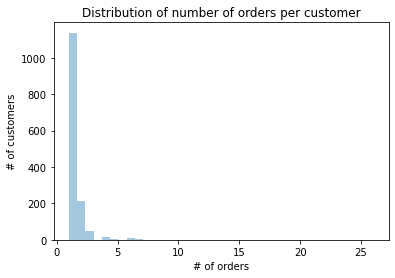

In [23]:
n_orders = lavval_preprocessed.groupby(['customer_id'])['id'].nunique()
mult_orders_perc = np.sum(n_orders > 1) / lavval_preprocessed['customer_id'].nunique()
print(f'{100 * mult_orders_perc:.2f}% of customers ordered more than once.')

ax = sns.distplot(n_orders, kde=False, hist=True)
ax.set(title='Distribution of number of orders per customer',
       xlabel='# of orders', 
       ylabel='# of customers');

C:\Users\wslee.2019\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


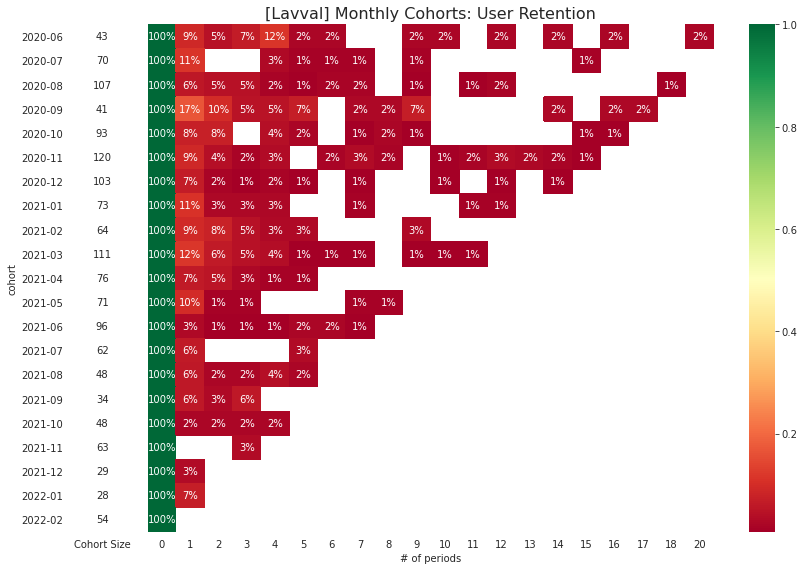

In [29]:
df = lavval_preprocessed[['customer_id', 'id', 'created_at']].drop_duplicates()

df['order_month'] = df['created_at'].dt.to_period('M')
df['cohort'] = df.groupby('customer_id')['created_at'] \
                 .transform('min') \
                 .dt.to_period('M') 
df_cohort = df.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('customer_id', 'nunique')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)                                

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', #YlGnBu (blue)
                ax=ax[1])
    ax[1].set_title('[Lavval] Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'Cohort Size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()
    plt.savefig('../customer_retention_output/lavval_cohort_analysis.pdf')

NewAgeFSG

17.80% of customers ordered more than once.


C:\Users\wslee.2019\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


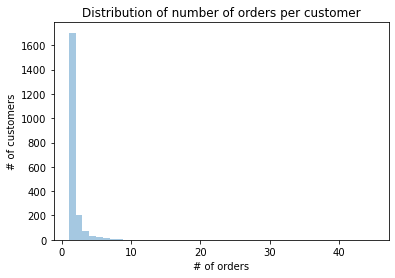

In [27]:
n_orders = newagefsg_preprocessed.groupby(['customer_id'])['id'].nunique()
mult_orders_perc = np.sum(n_orders > 1) / newagefsg_preprocessed['customer_id'].nunique()
print(f'{100 * mult_orders_perc:.2f}% of customers ordered more than once.')

ax = sns.distplot(n_orders, kde=False, hist=True)
ax.set(title='Distribution of number of orders per customer',
       xlabel='# of orders', 
       ylabel='# of customers');

C:\Users\wslee.2019\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


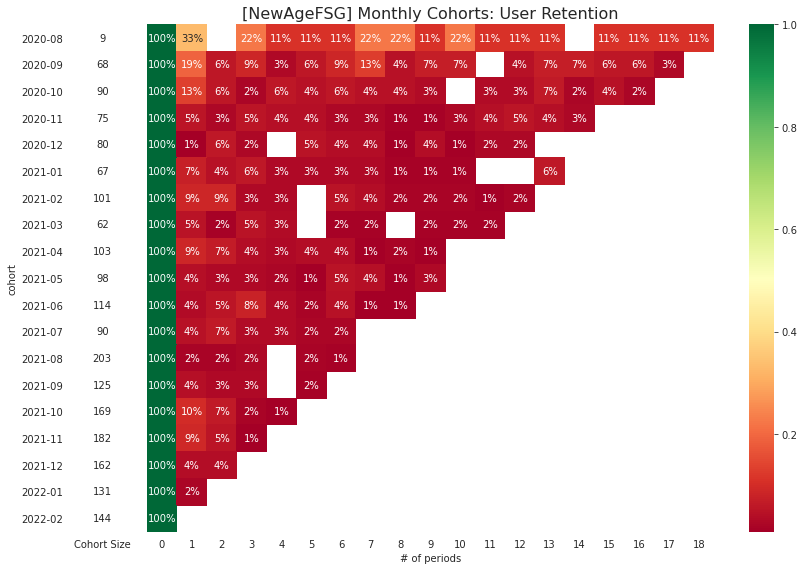

In [30]:
df = newagefsg_preprocessed[['customer_id', 'id', 'created_at']].drop_duplicates()

df['order_month'] = df['created_at'].dt.to_period('M')
df['cohort'] = df.groupby('customer_id')['created_at'] \
                 .transform('min') \
                 .dt.to_period('M') 
df_cohort = df.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('customer_id', 'nunique')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)                                

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', #YlGnBu (blue)
                ax=ax[1])
    ax[1].set_title('[NewAgeFSG] Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'Cohort Size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()
    plt.savefig('../customer_retention_output/newagefsg_cohort_analysis.pdf')